This notebook compares the domain-averaged variance of vorticity budget terms as a function of filtering scale in different regions. The approach helps us to undersntad the role of different terms at different scales.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import xesmf as xe
import gcm_filters
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:35323 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 405.20 GB


In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,20))
    #gl.xlocator = mticker.FixedLocator(np.arange(-170,180,60))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
ppdir = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/"

ds = xr.open_dataset(ppdir + "OM4p25_JRA55_Vorticity_Budget_Season.nc", chunks = {'season':1})
ds1 =  xr.open_dataset(ppdir + "OM4p25_JRA55_TS_Season.nc", chunks = {'season':1})
ds = xr.merge([ds, ds1])

print(ds)

<xarray.Dataset>
Dimensions:       (season: 4, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * season        (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    beta_V        (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    BPT           (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_Adv      (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taus     (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_taub     (season, yq, xq) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    Curl_diff

#### Filter with different scale_factor

In [40]:
#case = 'Fixed_Factor'
case = 'Fixed_Scale'

filer_type = 'Guassian'
#filer_type = 'Taper' # leading to numerical instability, avoid for now

In [5]:
%%time 

# This is for filtering by fixed scale factor only

fldlist = ['beta_V', 'BPT','Mass_flux','eta_dt','Curl_dudt','Curl_taus','Curl_taub','Curl_Adv','Curl_diff']

dims = ['yq', 'xq']

filter_scale = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40] # filter to 1 deg, 2 deg upto 10 deg

ds1 = ds.astype(np.float64)
area = ds1['areacello_bu']
wet_mask = ds1['wet_c']

ds_filter = []

for scale in filter_scale:
    
    ds_tmp = xr.Dataset()
    
    if(filer_type == 'Guassian'):
        filter_Deg = gcm_filters.Filter(filter_scale=scale, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                                        grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,
                                        grid_vars={'wet_mask': wet_mask})
    elif(filer_type == 'Taper'):
        filter_Deg = gcm_filters.Filter(filter_scale=scale, dx_min=1, filter_shape=gcm_filters.FilterShape.TAPER,
                                        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                                        grid_vars={'wet_mask': wet_mask})
    
    for fld in fldlist:
    
        tmp = filter_Deg.apply(ds1[fld] * area, dims=dims)
        ds_tmp[fld] = (tmp/area).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})
        
    ds_filter.append(ds_tmp)

CPU times: user 40.5 s, sys: 10.4 s, total: 50.8 s
Wall time: 8min 32s


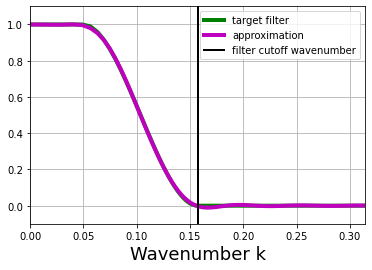

In [6]:
filter_Deg.plot_shape()

In [27]:
%%time 

# This is for filtering by fixed length scale only

fldlist = ['beta_V', 'BPT','Mass_flux','eta_dt','Curl_dudt','Curl_taus','Curl_taub','Curl_Adv','Curl_diff']

filter_scale = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

dims = ['yq', 'xq']

ds1 = ds.astype(np.float64)
area = ds1['areacello_bu']
wet_mask = ds1['wet_c']

# follow https://gcm-filters.readthedocs.io/en/latest/tutorial_tripole_grid.html

dxe = ds1.dxCv.swap_dims({"xh": "xq"}).roll(xq=-1, roll_coords=False) # x-spacing centered at eastern q-cell edge in m
dye = ds1.dyCv.swap_dims({"xh": "xq"}).roll(xq=-1, roll_coords=False) # y-spacing centered at eastern q-cell edge in m
dxn = ds1.dxCu.swap_dims({"yh": "yq"}).roll(yq=-1, roll_coords=False) # x-spacing centered at northern q-cell edge in m
dyn = ds1.dyCu.swap_dims({"yh": "yq"}).roll(yq=-1, roll_coords=False) # y-spacing centered at northern q-cell edge in m

dx_min = min(dxe.where(wet_mask).min(), dye.where(wet_mask).min(), dxn.where(wet_mask).min(), dyn.where(wet_mask).min())
dx_min = dx_min.values

ds_filter = []

for scale in filter_scale:
    
    ds_tmp = xr.Dataset()
    
    tmp = np.asarray(scale)*100000./4.
    specs = {'filter_scale': tmp, 'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
             'dx_min': dx_min}
    
    filter_Deg = gcm_filters.Filter(**specs, grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
                                      grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 
                                                 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': area})
    
    for fld in fldlist:
    
        tmp = filter_Deg.apply(ds1[fld], dims=dims)
        ds_tmp[fld] = (tmp).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})
        
    ds_filter.append(ds_tmp)

CPU times: user 1min 48s, sys: 22.9 s, total: 2min 11s
Wall time: 23min 10s


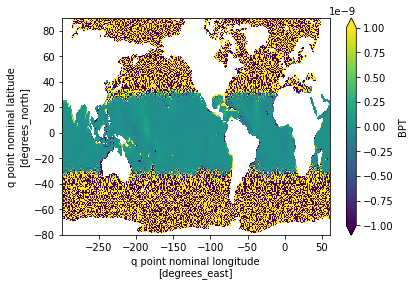

In [35]:
filter_scale = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
ds_filter[9]['BPT'].mean('season').plot(vmin=-1e-9, vmax=1e-9, cmap='viridis')

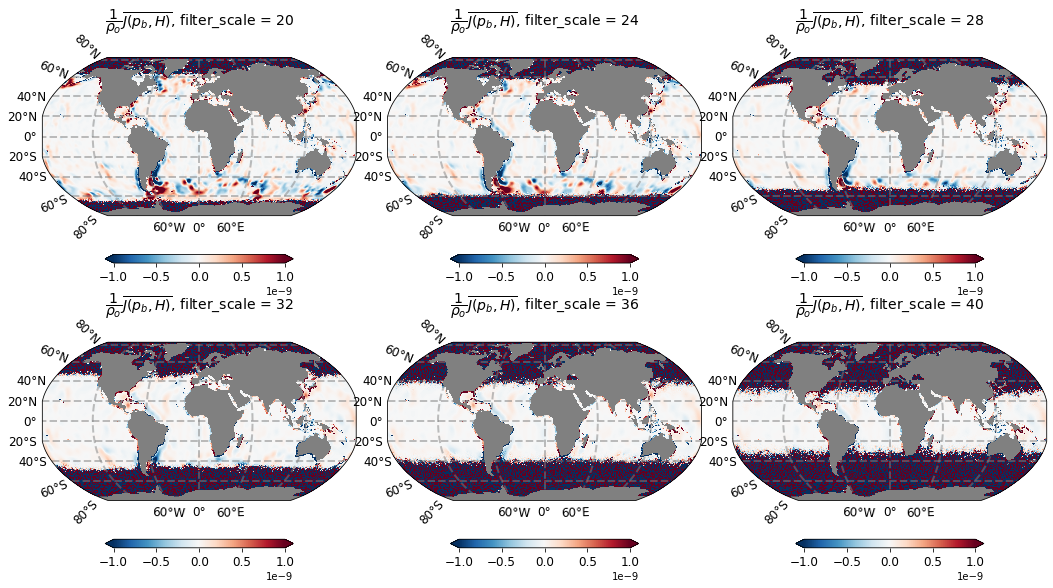

In [36]:
# Global map 1/4 deg (tripolar grid algorithm)

max_r = 1.e-9
max_r1 = 1.e-9

grid1 = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,10])

lat_lon_ext = [-180, 180, -85., 85.]

for i in range(4, len(filter_scale)):
    if(i<=6):
        j = 0; k = i-4;
    else:
        j = 1; k = i-3-4;
        
    BPT1 = ds_filter[i]['BPT'].mean('season').isel(yq=slice(0,1079))
    ax = fig.add_subplot(grid1[j, k], projection=ccrs.Robinson(),facecolor='grey')
    _ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                 lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
                 title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, filter_scale = ' + str(filter_scale[i]))

In [41]:
# Save Data 

save_file = "OMp25_JRA55_" + filer_type + "_" + case + ".nc"

ds_save = xr.concat(ds_filter, dim='filter')

if (case == 'Fixed_Factor'):
    tmp = np.asarray(filter_scale) /4.
    ds_save.coords['filter'] = tmp
    ds_save.filter.attrs['units'] = "Filter in Deg"
    
elif (case == 'Fixed_Scale'):
    tmp = np.asarray(filter_scale) * 100 / 4.
    ds_save.coords['filter'] = tmp
    ds_save.filter.attrs['units'] = "Filter in km"

print(ds_save)

<xarray.Dataset>
Dimensions:    (filter: 10, season: 4, xq: 1440, yq: 1080)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
    xh         (xq) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
    yh         (yq) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    geolat_c   (yq, xq) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon_c   (yq, xq) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * filter     (filter) float64 100.0 200.0 300.0 400.0 ... 800.0 900.0 1e+03
Data variables:
    beta_V     (filter, season, yq, xq) float64 nan nan nan nan ... nan nan nan
    BPT        (filter, season, yq, xq) float64 nan nan nan nan ... nan nan nan
    Mass_flux  (filter, season, yq, xq) float64 nan nan nan nan ... nan nan nan
    eta_dt     (filter, season, yq, xq) flo

In [43]:
path1 = "/archive/Hemant.Khatri/MOM_Budget/OM4p25_JRA55/v3_FW_adjust_True/Filter_Data/"
%time ds_save.load().to_netcdf(path1 + save_file)

CPU times: user 149 ms, sys: 3.19 s, total: 3.34 s
Wall time: 7.01 s


In [42]:
print(save_file)

OMp25_JRA55_Guassian_Fixed_Scale.nc


#### Decide on different regions

We choose 6 regions, i.e. North Atlantic (40$^{\circ}$N$-90^{\circ}$N, 100$^{\circ}$W$-30^{\circ}$E), Central Atlantic (40$^{\circ}$S$-40^{\circ}$N, 100$^{\circ}$W$-30^{\circ}$E), North Pacific (40$^{\circ}$N$-90^{\circ}$N, 120$^{\circ}$E$-100^{\circ}$W), Central Pacific (40$^{\circ}$S$-40^{\circ}$N, 120$^{\circ}$E$-100^{\circ}$W), Indian Ocean (40$^{\circ}$N$-90^{\circ}$N, 30$^{\circ}$E$-120^{\circ}$E), Southern Ocean (90$^{\circ}$S$-40^{\circ}$S)

For simlicity, just choose three, 40$^{\circ}$N$-90^{\circ}$N, 90$^{\circ}$S$-40^{\circ}$S, 40$^{\circ}$S$-40^{\circ}$S.

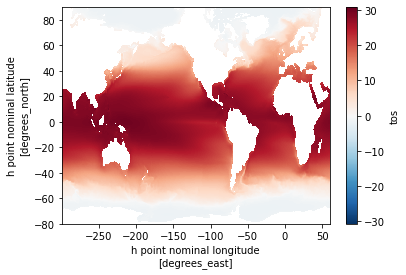

In [52]:
ds['tos'].mean('season').plot()

In [42]:
ds.close()
client.close()
cluster.close()